<a href="https://colab.research.google.com/github/george-kan/fastai/blob/main/Doggies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install --upgrade --force-reinstall --no-deps kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/kaggle"
!kaggle competitions download dog-breed-identification
!unzip "/content/dog-breed-identification"

Streaming output truncated to the last 5000 lines.
  inflating: train/001513dfcb2ffafc82cccf4d8bbaba97.jpg  
  inflating: train/001cdf01b096e06d78e9e5112d419397.jpg  
  inflating: train/002211c81b498ef88e1b40b9abf84e1d.jpg  
  inflating: train/003df8b8a8b05244b1d920bb6cf451f9.jpg  
  inflating: train/0042188c895a2f14ef64a918ed9c7b64.jpg  
  inflating: train/004396df1acd0f1247b740ca2b14616e.jpg  
  inflating: train/0067dc3eab0b3c3ef0439477624d85d6.jpg  
  inflating: train/00693b8bc2470375cc744a6391d397ec.jpg  
  inflating: train/0075dc49dab4024d12fafe67074d8a81.jpg  
  inflating: train/008887054b18ba3c7601792b6a453cc3.jpg  
  inflating: train/00a338a92e4e7bf543340dc849230e75.jpg  
  inflating: train/00a366d4b4a9bbb6c8a63126697b7656.jpg  
  inflating: train/00b7d114bc5166a629a3cc03d9329120.jpg  
  inflating: train/00ba244566e36e0af3d979320fd3017f.jpg  
  inflating: train/00ca18751837cd6a22813f8e221f7819.jpg  
  inflating: train/00ddcec076073cc96f82c27bf4548fbc.jpg  
  inflating: train/00

In [7]:
!pip install --upgrade fastai
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.vision.all import *
from fastai import *

Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (2.2.5)


In [8]:
labels = pd.read_csv('/content/labels.csv')
def label_func(fname):
    return labels.loc[labels.id == fname.name[:-4], 'breed'].item()

path = Path('/content/train/')

In [51]:
labels.groupby('breed').size().nsmallest(10)

breed
briard               66
eskimo_dog           66
brabancon_griffon    67
golden_retriever     67
komondor             67
german_shepherd      69
giant_schnauzer      69
otterhound           69
tibetan_mastiff      69
walker_hound         69
dtype: int64

In [5]:
import random
removed_samples = random.sample(path.ls(), 5000)
for doggie in removed_samples:
    doggie.unlink()

In [23]:
path.ls()

(#5222) [Path('/content/train/269943ddbcdae9ecf9f1eccd95503173.jpg'),Path('/content/train/e87a86f29c8709e81bbea9c8139d739c.jpg'),Path('/content/train/be32d9afea6b7ddb96724df1e617873d.jpg'),Path('/content/train/9df5e6ab4c12f8cddd6bc3ed343251f8.jpg'),Path('/content/train/be188d4334b4954ea69e16290c396fa1.jpg'),Path('/content/train/daf1dde58cb4cb4d55bf4e4874e76153.jpg'),Path('/content/train/12c9f56e73ac9f4a08afb142f89051ae.jpg'),Path('/content/train/e866558cded733e2788c68b170752f59.jpg'),Path('/content/train/329cc823101c76d6f7c066d05f02d5e2.jpg'),Path('/content/train/5811c9b5aa472c3596347c4467d9acd6.jpg')...]

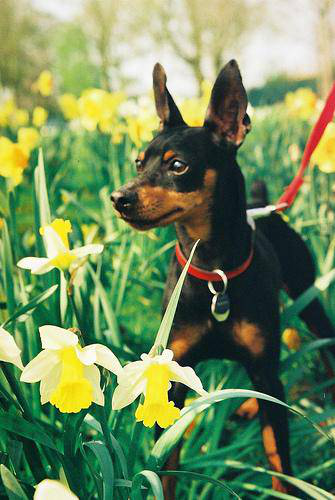

In [24]:
Image.open(path.ls()[1002])

In [9]:
dogs = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed = 42),
    get_y = label_func,
    item_tfms = Resize(460),
    batch_tfms = aug_transforms(size=224, mult=2, min_scale=0.5, flip_vert = True))

dls = dogs.dataloaders(path, batch_size = 150)
#dls = dogs.dataloaders(temp_path, batch_size = 150)
#batch_tfms = aug_transforms(size=224, mult=2, min_scale=0.5))

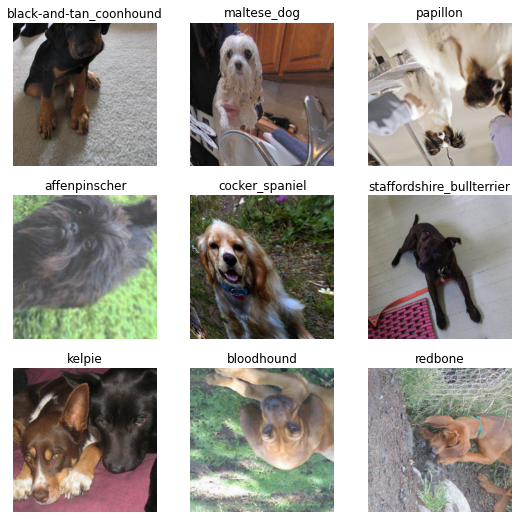

In [26]:
dls.train.show_batch()

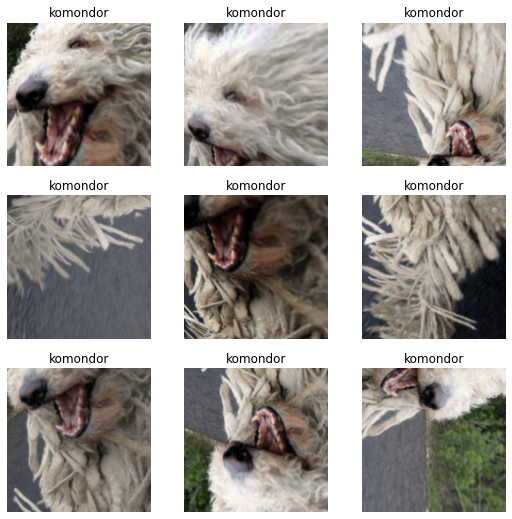

In [10]:
dls.train.show_batch(unique= True)

In [11]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy()).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [29]:
learn.fine_tune(15)

epoch,train_loss,valid_loss,accuracy,time
0,4.770851,1.957807,0.685824,00:47


epoch,train_loss,valid_loss,accuracy,time
0,2.811572,1.709304,0.774904,00:48
1,2.606004,1.621016,0.802682,00:48
2,2.474821,1.597143,0.809387,00:48
3,2.335728,1.642395,0.793103,00:48
4,2.229413,1.623350,0.783525,00:48
5,2.144282,1.643985,0.771073,00:48
6,2.039712,1.630438,0.776820,00:48
7,1.944929,1.584942,0.795977,00:48
8,1.855476,1.569591,0.800766,00:48
9,1.755402,1.545820,0.795019,00:48


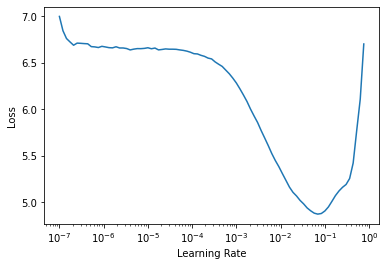

In [68]:
lr_min, lr_steep = learn.lr_find()

In [71]:
??learn.fine_tune

In [12]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.522537,1.881517,0.745108,01:33
1,2.641707,1.622797,0.784736,01:30
2,2.249068,1.547009,0.810176,01:30


SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=9.12010818865383e-07)

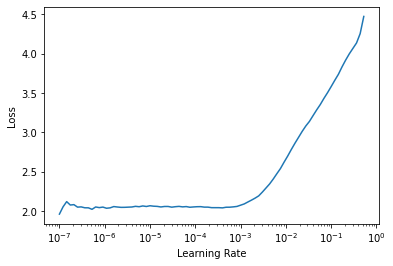

In [13]:
learn.unfreeze()
learn.lr_find()

In [14]:
learn.fit_one_cycle(10, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,2.021299,1.536489,0.812622,01:33
1,1.989795,1.517972,0.818004,01:33
2,1.990689,1.510192,0.818493,01:33
3,1.962276,1.496343,0.825342,01:34
4,1.924886,1.490538,0.822896,01:35
5,1.893206,1.478882,0.822896,01:34
6,1.878252,1.476277,0.826810,01:34
7,1.860875,1.467856,0.828767,01:34
8,1.841481,1.471310,0.827789,01:34
9,1.844844,1.475447,0.825342,01:33


In [41]:
interp = ClassificationInterpretation.from_learner(learn)

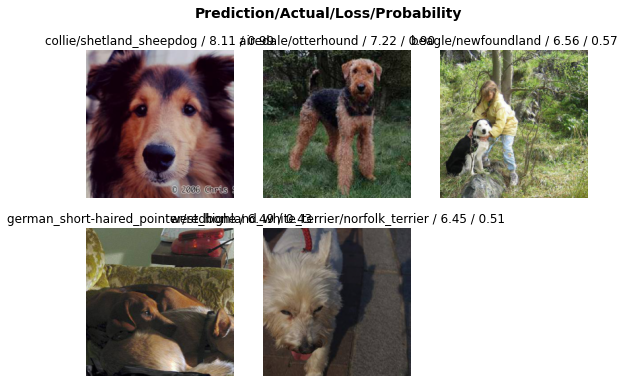

In [42]:
interp.plot_top_losses(5)

In [54]:
losses = interp.most_confused()

In [61]:
pd.Series([x[0] for x in losses], name = 'Incorrect').value_counts().head(10)

standard_poodle                   5
norfolk_terrier                   5
american_staffordshire_terrier    5
wire-haired_fox_terrier           4
golden_retriever                  4
german_shepherd                   4
english_foxhound                  4
rottweiler                        4
lhasa                             4
otterhound                        4
Name: Incorrect, dtype: int64

In [66]:
labels.loc[labels.breed == 'standard_poodle']

,id,breed
274,068314c65cbe67fa4f57283f4f3a801c,standard_poodle
523,0cb5839c82f7c1286e55f260d4e608c4,standard_poodle
601,0eb00c6fc429ecc2cf8745a6334594ad,standard_poodle
899,160160c8ac562966448486906cb56308,standard_poodle
1086,1ae80c7e781d72681bc8e582a703919d,standard_poodle
...,...,...
9477,ed9c22ad21413691f548f5d72e7a76d9,standard_poodle
9541,ef22e67b6d82c04f2d17249e42769d35,standard_poodle
9663,f33c92eca07a03a242b4a9986fc66d9b,standard_poodle
9690,f3cf90e3a8a78d31850eca467122183a,standard_poodle


In [15]:
test_path = Path('/content/test/')
tst_files = get_image_files(test_path)
tst_dl = dls.test_dl(tst_files)

In [16]:
predictions = learn.tta(dl = tst_dl)

In [17]:
sub = pd.DataFrame(predictions[0].numpy())
sub.columns = learn.dls.vocab
sub.insert(0, column = 'id', value = [x.name[:-4] for x in test_path.ls()])

In [18]:
sub.to_csv('submission.csv', index=False)

In [19]:
!kaggle competitions submit -f /content/submission.csv -m something dog-breed-identification

100% 16.1M/16.1M [00:00<00:00, 30.6MB/s]
Successfully submitted to Dog Breed Identification

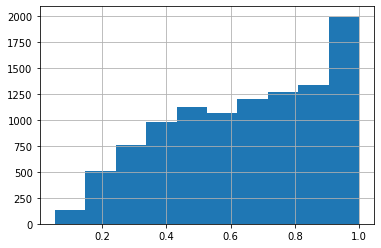

In [40]:
import matplotlib.pyplot as plt
sub.max(axis = 1).hist()